In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
# 一些超参数
learning_rate = 1e-3
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset('Nan-Do/code-search-net-python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repo'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00004-ee77a7de79eb2ab2.parquet:   0%|          | 0.00/155M [00:00<?, ?B/s]

(…)-00001-of-00004-648b3bede2edf6e6.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

(…)-00002-of-00004-1dfd72b171e6b205.parquet:   0%|          | 0.00/153M [00:00<?, ?B/s]

(…)-00003-of-00004-184ab6d0e3c690b1.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

Filter:   0%|          | 0/455243 [00:00<?, ? examples/s]

In [4]:
class RNNCell(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.inputs_size = input_size
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(self.inputs_size + self.hidden_size, self.hidden_size)

  def forward(self, input, hidden=None):
    # input:  (1, I),在NLP领域，I等于文本嵌入的C
    # hidden: (1, H)
    if hidden is None:
      hidden = self.init_hidden(input.device)
    combined = torch.concat((input, hidden), dim=-1)  # (1, I + H)
    hidden = F.relu(self.i2h(combined))    # (1,    H)
    return hidden

  def init_hidden(self, device):
    return torch.zeros((1, self.hidden_size), device=device)

In [5]:
r_model = RNNCell(2, 3)
data = torch.randn(4, 1, 2) # 四个句子，每个句子的的形状是(1, 2)
hidden = None

# 因为RNN是按序计算，不能并行，所以要手动循环每个句子
for i in range(data.shape[0]):
  hidden = r_model(data[i], hidden)
  print(hidden)

tensor([[0.0973, 0.0144, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.0000, 0.4002]], grad_fn=<ReluBackward0>)
tensor([[0.0000, 0.3787, 0.0000]], grad_fn=<ReluBackward0>)
tensor([[0.0218, 0.1896, 0.0000]], grad_fn=<ReluBackward0>)


In [6]:
class CharRNN(nn.Module):
  def __init__(self, vs):
    super().__init__()
    self.emb = nn.Embedding(vs, 30)
    self.rnn = RNNCell(30, 50)
    self.lm = nn.Linear(50, vs)

  def forward(self, x, hidden=None):
    # x : (1)
    # hidden : (1, 50)
    embeddings = self.emb(x) # (1, 30)
    hidden = self.rnn(embeddings, hidden)
    out = self.lm(hidden) # (1, vs)
    return out, hidden



In [7]:
class CharTokenizer:

  def __init__(self, data, end_ind=0):
    # data:list[str]
    # 得到所有的字符
    chars = sorted(list(set(''.join(data))))
    self.char2ind = {s : i+1 for i, s in enumerate(chars)}
    self.char2ind['<|e|>'] = end_ind
    self.ind2char = {v : k for k, v in self.char2ind.items()}
    self.end_ind = end_ind

  def encode(self, x):
    return [self.char2ind[c] for c in x]

  def decode(self, x):
    # x : int or list[int]
    if isinstance(x, int):
      return self.ind2char[x]
    return [self.ind2char[i] for i in x]

In [8]:
tokenizer = CharTokenizer(data=datasets['original_string'])
test_str = 'def f(x):'
encode_result = tokenizer.encode(test_str)
decode_result = tokenizer.decode(encode_result)
print(encode_result, ''.join(decode_result))

[70, 71, 72, 2, 72, 10, 90, 11, 28] def f(x):


In [9]:
c_model = CharRNN(len(tokenizer.char2ind)).to(device)

In [10]:
c_model

CharRNN(
  (emb): Embedding(98, 30)
  (rnn): RNNCell(
    (i2h): Linear(in_features=80, out_features=50, bias=True)
  )
  (lm): Linear(in_features=50, out_features=98, bias=True)
)

In [11]:
inputs = torch.tensor(tokenizer.encode('d'), device=device)
out, hidden = c_model(inputs)
out.shape, hidden.shape

(torch.Size([1, 98]), torch.Size([1, 50]))

In [12]:
@torch.no_grad()
def generate(model, idx, tokenizer, max_new_tokens=300):
  # idx : (1)
  out = idx.tolist()
  hidden = None
  model.eval()
  for _ in range(max_new_tokens):
    logits, hidden = model(idx, hidden)
    probs = F.softmax(logits, dim=-1) #(1, 98)
    # 随机生成文本
    ix = torch.multinomial(probs, num_samples=1) # (1, 1)
    out.append(ix.item())
    idx = ix.squeeze(0)
    if out[-1] == tokenizer.end_ind:
      break
  model.train()
  return out

In [13]:
inputs = torch.tensor(tokenizer.encode('d'), device=device)
''.join(tokenizer.decode(generate(c_model, inputs, tokenizer)))

'd*ZO(m/of("YP{BZE G|uw=3:1\'Z$?Q9)N[{KQ=CK(AM:iKcaR;+Q3j<sAegWS$ö0Px!q9T3"yum5Za)\'W~]\\Wm&B"({r\ncdtM=^DA11zk<|e|>'

In [14]:
def process(text, tokenizer):
  # text : str
  enc = tokenizer.encode(text)
  inputs = enc
  labels = enc[1:] + [tokenizer.end_ind]
  return torch.tensor(inputs, device=device), torch.tensor(labels, device=device)

In [15]:
process(test_str, tokenizer)

(tensor([70, 71, 72,  2, 72, 10, 90, 11, 28], device='cuda:0'),
 tensor([71, 72,  2, 72, 10, 90, 11, 28,  0], device='cuda:0'))

In [16]:
lossi = []
epochs = 1
optimizer = optim.Adam(c_model.parameters(), lr=learning_rate)

for e in range(epochs):
  for data in datasets:
    inputs, labels = process(data['original_string'], tokenizer)
    hidden = None
    _loss = 0.0
    lens = len(inputs)
    for i in range(lens):
      logits, hidden = c_model(inputs[i].unsqueeze(0), hidden)
      _loss += F.cross_entropy(logits, labels[i].unsqueeze(0)) / lens
    lossi.append(_loss.item())
    optimizer.zero_grad()
    _loss.backward()
    optimizer.step()

In [17]:
inputs = torch.tensor(tokenizer.encode('d'), device=device)
print(''.join(tokenizer.decode(generate(c_model, inputs, tokenizer))))

daelars itT in ciwPione)
            a  pererasestyby ssseetcrt "con chex):
        it the = _painvorn ares intode, saliopturn WeperavaFsedf Tisthonted thing s % ist(mogtor :
           oetom Jueised tram   ""
         /the sorm siltoUf_<'ath  nsc)<|e|>


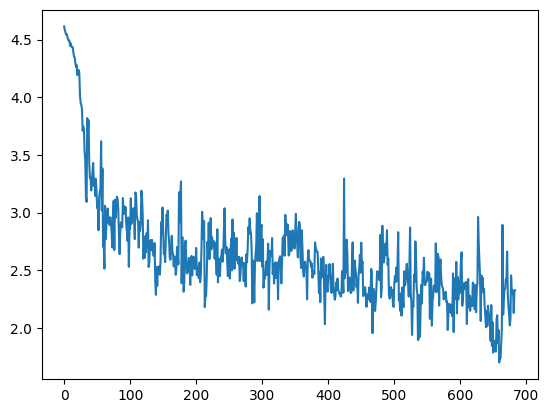

In [18]:
plt.plot(lossi)